# Sparse Matrix Framework: Error Checking for Muncie

In [1]:
# import packages
import xarray as xr 
import numpy as np
from scipy.sparse import *
from scipy.sparse.linalg import *
import matplotlib.pyplot as plt

In [2]:
# Open Zarr
ds_zarr = xr.open_zarr('muncie.zarr',
                       consolidated=True,  # http://xarray.pydata.org/en/stable/user-guide/io.html#consolidated-metadata
                      )

### Left-Hand Side

Because of the functionality of the `csr_matrix` function ([see documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)), we do not need to place each coefficient within the sparse matrix ourselves. Instead, we can define the row/column indices and then some data that should fall within that cell of the sparse matrix. The `scipy` `csr_matrix` function will take care of summing those coefficient values within each cell!  

General items below:
* Advection term:
    * [Upwind Differencing](https://www.youtube.com/watch?v=JVE0fNkc540)
* Leverage numpy operators  

The `LHS` class below defines all row/column indices and corresponding data values from the descritized total-load advection-diffusion equation.  

In [3]:
class LHS:
    def __init__(self, ds, t):
        '''
        ds: xarray containing all geometry and ouptut results from RAS2D.
            Should follow UGRID conventions.
        params: A class instance containing additional parameters. 
            TBD if this will remain or if parameters will be integrated into xarray.
        t: timestep index  
        '''
        return

    def updateValues(self, ds,  t):
        flow_out_indices = np.where(ds['advection_coeff'][t+1] > 0)[0]
        flow_in_indices = np.where(ds['advection_coeff'][t+1] < 0)[0]
        print(flow_in_indices)
        print(flow_out_indices)

        # initialize arrays that will define the sparse matrix
        len_val = len(ds['nedge']) * 2 + len(ds['nface']) * 2 + len(flow_out_indices) * 2 + len(flow_in_indices)*2
        self.rows = np.zeros(len_val)
        self.cols = np.zeros(len_val)
        self.coef = np.zeros(len_val)

        ###### diagonal terms - the "A" coefficient in the equations detailed above
        start = 0
        end = len(ds['nface'])
        self.rows[start:end] = ds['nface']
        self.cols[start:end] = ds['nface']
        seconds = ds['dt'].values[t] #  np.timedelta64(1, 's'))
        print("seconds", seconds)
        self.coef[start:end] = ds['volume'][t+1] / seconds + ds['sum_coeff_to_diffusion'][t+1]
        plt.plot(range(len(ds['volume'][t+1])), ds['volume'][t+1].values)
        plt.title("Volumes")
        plt.show()
        v0 = np.where(ds['volume'][t]> 0)
        print(v0)


        # add ghost cell volumes tp diagonals
        # note: these values are 0 for cell that is NOT a ghost cell
        # note: also 0 for any ghost cell that is not RECEIVING flow 
        start = end
        end = end + len(ds['nface'])
        self.rows[start:end] = ds['nface']
        self.cols[start:end] = ds['nface']
        self.coef[start:end] = ds['ghost_volumes'][t+1] / seconds
        plt.plot(range(len(ds['ghost_volumes'][t+1])), ds['ghost_volumes'][t+1].values)
        plt.title("Ghost Volumes")
        plt.show()

        ###### advection
        # sometimes on-diagonal, sometimes off-diagonal (upwind differencing)

        # if statement to prevent errors if flow_out_indices or flow_in_indices have length of 0
        if len(flow_out_indices) > 0:
            # update indices
            start = end
            end = end + len(flow_out_indices)

            # where advection coefficient is positive, the concentration across the face will be the REFERENCE CELL 
            # so the the coefficient will go in the diagonal - both row and column will equal diag_cell
            self.rows[start:end] = ds['edge_face_connectivity'].T[0][flow_out_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[0][flow_out_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_out_indices]

            # subtract from corresponding neighbor cell (off-diagonal)
            start = end
            end = end + len(flow_out_indices)
            self.rows[start:end] = ds['edge_face_connectivity'].T[1][flow_out_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[0][flow_out_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_out_indices] * -1
        else:
            pass

        if len(flow_in_indices) > 0:
            # update indices
            start = end
            end = end + len(flow_in_indices)

            ## where it is negative, the concentration across the face will be the neighbor cell ("N")
            ## so the coefficient will be off-diagonal 
            self.rows[start:end] = ds['edge_face_connectivity'].T[0][flow_in_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[1][flow_in_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_in_indices] 

            ## update indices 
            start = end
            end = end + len(flow_in_indices)
            ## do the opposite on the corresponding diagonal 
            self.rows[start:end] = ds['edge_face_connectivity'].T[1][flow_in_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[1][flow_in_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_in_indices]  * -1 
        else:
            pass

        ###### off-diagonal terms - diffusion
        f1 = ds['edge_face_connectivity'].T[0]
        f2 = ds['edge_face_connectivity'].T[1]

        # update indices
        start = end
        end = end + len(ds['nedge'])
        print(end-start)
        self.rows[start:end] = f1
        self.cols[start:end] = f2
        self.coef[start:end] = -1 * ds['coeff_to_diffusion'][t+1]

        # update indices and repeat 
        start = end
        end = end + len(ds['nedge'])
        print(end)
        print(len(self.coef))
        
        self.cols[start:end] = f1
        self.rows[start:end] = f2
        self.coef[start:end] = -1 * ds['coeff_to_diffusion'][t+1] # last one


In [4]:
import pandas as pd
df_test = pd.DataFrame(ds_zarr['volume'])

df_test[0][136]

10.307330131530762

[]
[]
seconds 300.0


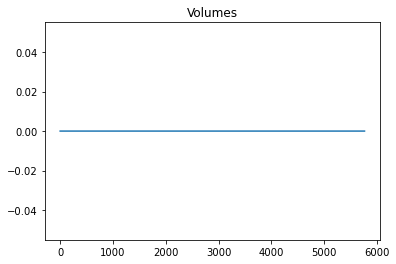

(array([], dtype=int64),)


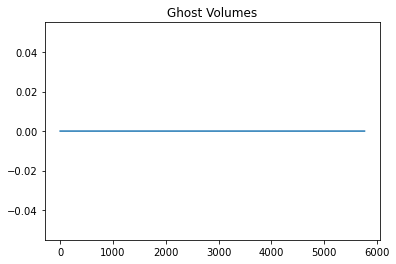

11164
33858
33858


In [5]:
# test at single timestep
t = 0
lhs = LHS(ds_zarr, t)
lhs.updateValues(ds_zarr, t)

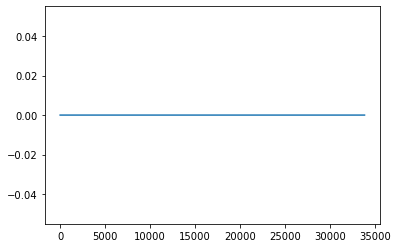

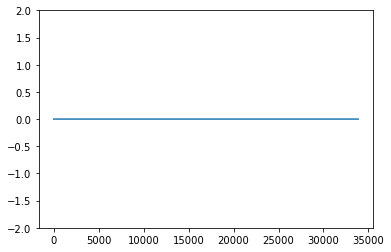

In [6]:
# plot coefficients
# as expected, coefficients to the advection term are much higher than coefficients to the diffusion terms
import matplotlib.pyplot as plt
plt.plot(lhs.coef)
plt.show()
plt.plot(lhs.coef)
plt.ylim(-2,2)
plt.show()

### Compressed Sparse Row Matrix

Use the `csr_matrix` function in the `scipy` library to format the left-hand side **A** matrix. 

MODFLOW-USG uses the CSR format for the **A** matrix. All nonzero coefficients in a row of the matrix are stored sequentially, beginning with the first one in the row and ending with the last. The MODFLOW-USG documentation contains some useful details on how these matrices are defined in their [theoretical documentation](https://pubs.usgs.gov/tm/06/a45/pdf/tm6-A45.pdf), starting on page 32. Essentially, it can help with computational efficiency. We are most interested in the ease with which it allows us to set up our sparse matrix. 

In [7]:
A = csr_matrix( (lhs.coef,(lhs.rows, lhs.cols)), shape=(len(ds_zarr['nface']),len(ds_zarr['nface'])))


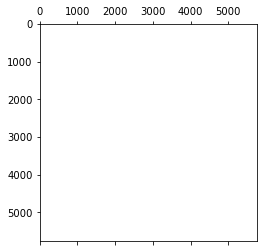

In [8]:
# artificially produce solution
# A.dot(b)
plt.spy(A)

### Right-Hand Side Vector
The right-hand side vector will be a `NCELL x 1` matrix that stores the total load in the current timestep plus the total load source/sink term (M/T/L2):

$\frac{V_P^{n}C_P^{n}}{\Delta t \beta_P^{n}} + S_PA_P$

* $V_P^{n}$ is the volume at the current timestep. 
* $C_P^{n}$ is the concentration at the current timestep. Provided from solving the previous timestep OR from initial conditions. 
* $ \beta_P^{n}$ and $S_PA_P$ are given? Need to ask more. 


In [9]:
class RHS:
    def __init__(self, ds, t):
        '''
        ds: xarray containing all geometry and ouptut results from RAS2D.
            Should follow UGRID conventions.
        params: A class instance containing additional parameters. 
            TBD if this will remain or if parameters will be integrated into xarray.
        t: timestep index  
        '''
        self.conc = np.zeros(len(ds['nface']))
        # self.conc[3673] = 0
        self.vals = np.zeros(len(ds['nface']))
        seconds = ds['dt'].values[t] #  / np.timedelta64(1, 's'))
        self.vals[:] = ds['volume'][t] / seconds * self.conc  # eventually also need to add total-load source/sink term (M/T/L2)
        print(np.where(ds['volume'][t] > 0))
        
    def updateValues(self, vector, ds, t):
        seconds = ds['dt'].values[t] # / np.timedelta64(1, 's'))
        self.vals[:] = vector * ds['volume'][t] / seconds

In [10]:
# test at single timestep
rhs = RHS(ds_zarr, t)
print(rhs.conc)
print(rhs.vals)

(array([], dtype=int64),)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


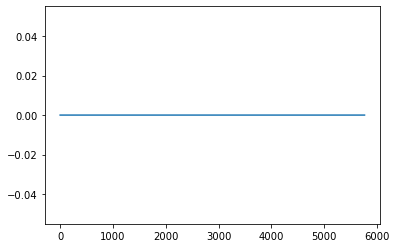

In [11]:
plt.plot(range(len(rhs.vals)), rhs.vals)

### Solve 

Use `scipy`'s `spsolve` function. Perhaps we could add a few links here based on the results of Peter's research showing this method is good + fast. 

In [12]:
b = rhs.vals
x = spsolve(A, b)

C:\Users\sjordan\Anaconda3\envs\ras2d_wq\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [13]:
x

array([nan, nan, nan, ..., nan, nan, nan])

In [14]:
np.allclose(A.dot(x), b)

False

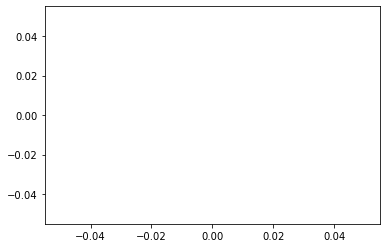

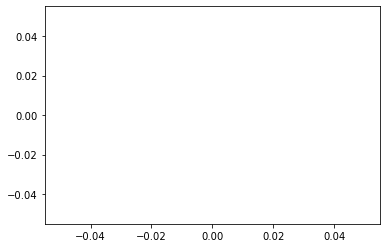

In [15]:
plt.plot(range(len(x)), x)
plt.show()
plt.plot(range(10), x[0:10])
plt.show()

## Troubleshooting

### Plot Volumes at t and t+1

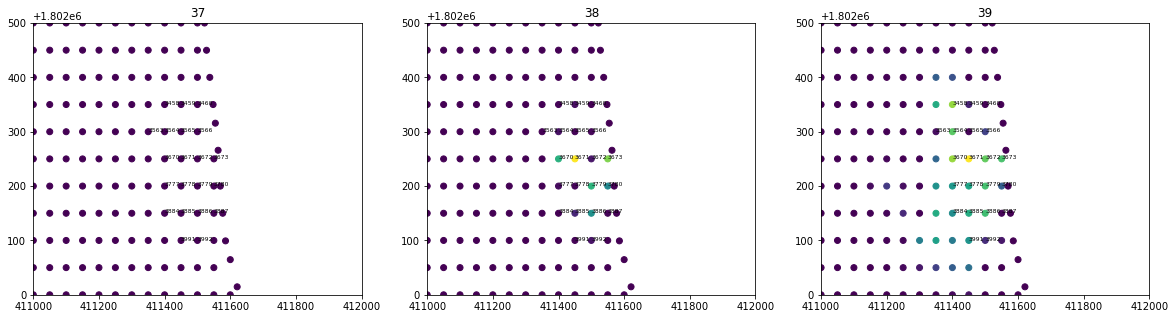

In [16]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)

times = [37, 38, 39]
for t in range(len(times)):
    x = ds_zarr.face_x
    y = ds_zarr.face_y
    ax[t].scatter(x,y, c=ds_zarr.volume[times[t]])
    ax[t].set_title(times[t])
    
for a in ax:
    a.set_ylim(1.8020 * 10**6, 1.8025*10**6)
    a.set_xlim(411000, 412000)
    for v in [3458, 3459, 3460, 3563, 3564, 3565, 3566, 3670, 3671, 3672, 3673, 3777, 3778, 3779, 3780, 3884, 3885, 3886, 3887, 3991, 3992]:
        a.annotate(v, (x[v], y[v]), fontsize=6)

plt.show()

### Try Advection Only

In [17]:
class LHS:
    def __init__(self, ds, t):
        '''
        ds: xarray containing all geometry and ouptut results from RAS2D.
            Should follow UGRID conventions.
        params: A class instance containing additional parameters. 
            TBD if this will remain or if parameters will be integrated into xarray.
        t: timestep index  
        '''
        return

    def updateValues(self, ds,  t):
        flow_out_indices = np.where(ds['advection_coeff'][t+1] > 0)[0]
        flow_in_indices = np.where(ds['advection_coeff'][t+1] < 0)[0]
        print(flow_in_indices)
        print(flow_out_indices)

        # initialize arrays that will define the sparse matrix
        len_val = len(ds['nedge']) * 2 + len(ds['nface']) * 2 + len(flow_out_indices) * 2 + len(flow_in_indices)*2
        self.rows = np.zeros(len_val)
        self.cols = np.zeros(len_val)
        self.coef = np.zeros(len_val)

        ###### diagonal terms - the "A" coefficient in the equations detailed above
        start = 0
        end = len(ds['nface'])
        self.rows[start:end] = ds['nface']
        self.cols[start:end] = ds['nface']
        seconds = ds['dt'].values[t] #  np.timedelta64(1, 's'))
        self.coef[start:end] = ds['volume'][t+1] / seconds


        # add ghost cell volumes tp diagonals
        # note: these values are 0 for cell that is NOT a ghost cell
        # note: also 0 for any ghost cell that is not RECEIVING flow 
        start = end
        end = end + len(ds['nface'])
        self.rows[start:end] = ds['nface']
        self.cols[start:end] = ds['nface']
        self.coef[start:end] = ds['ghost_volumes'][t+1] / seconds
        plt.plot(range(len(ds['ghost_volumes'][t+1])), ds['ghost_volumes'][t+1].values)
        plt.title("Ghost Volumes")
        plt.show()

        ###### advection
        # sometimes on-diagonal, sometimes off-diagonal (upwind differencing)

        # if statement to prevent errors if flow_out_indices or flow_in_indices have length of 0
        if len(flow_out_indices) > 0:
            # update indices
            start = end
            end = end + len(flow_out_indices)

            # where advection coefficient is positive, the concentration across the face will be the REFERENCE CELL 
            # so the the coefficient will go in the diagonal - both row and column will equal diag_cell
            self.rows[start:end] = ds['edge_face_connectivity'].T[0][flow_out_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[0][flow_out_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_out_indices]

            # subtract from corresponding neighbor cell (off-diagonal)
            start = end
            end = end + len(flow_out_indices)
            self.rows[start:end] = ds['edge_face_connectivity'].T[1][flow_out_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[0][flow_out_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_out_indices] * -1
        else:
            pass

        if len(flow_in_indices) > 0:
            # update indices
            start = end
            end = end + len(flow_in_indices)

            ## where it is negative, the concentration across the face will be the neighbor cell ("N")
            ## so the coefficient will be off-diagonal 
            self.rows[start:end] = ds['edge_face_connectivity'].T[0][flow_in_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[1][flow_in_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_in_indices] 

            ## update indices 
            start = end
            end = end + len(flow_in_indices)
            ## do the opposite on the corresponding diagonal 
            self.rows[start:end] = ds['edge_face_connectivity'].T[1][flow_in_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[1][flow_in_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_in_indices]  * -1 
        else:
            pass


[5692 5696 5700 6883 7071 7096 7097 7253 7262 7273 7287 7288 7528 7529
 7539 7552 7553 7752 7753 7758 7764 7770 7966 7976 7983 7984 7985 7987
 7989 8003 8199 8210 8212 8218 8225 8226 8229 8233 8425 8436 8442 8446
 8452 8453 8456 8670 8676 8683 8686 8688 8689 8890 8904 8907]
[5691 5694 5695 5697 5698 5699 6884 7095 7263 7286 7519 7551 7743 7763
 7766 7768 7769 7967 7975 7979 7986 8001 8002 8200 8211 8217 8224 8227
 8231 8232 8426 8435 8441 8447 8450 8454 8455 8660 8669 8675 8681 8682
 8687 8879 8880 8889 8895 8900 8905]


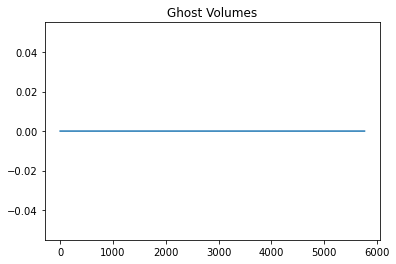

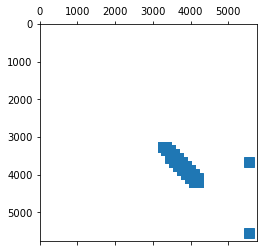

In [18]:
# test at single timestep
t = 38
lhs = LHS(ds_zarr, t)
lhs.updateValues(ds_zarr, t)
A = csr_matrix( (lhs.coef,(lhs.rows, lhs.cols)), shape=(len(ds_zarr['nface']),len(ds_zarr['nface'])))

# artificially produce solution
# A.dot(b)
plt.spy(A)

In [19]:
for e in A.toarray():
    if len(np.where(e>0)[0]) > 0:
        print(np.where(e > 0))

(array([3261], dtype=int64),)
(array([3262], dtype=int64),)
(array([3351], dtype=int64),)
(array([3352], dtype=int64),)
(array([3353], dtype=int64),)
(array([3354], dtype=int64),)
(array([3456], dtype=int64),)
(array([3457], dtype=int64),)
(array([3458], dtype=int64),)
(array([3459], dtype=int64),)
(array([3460], dtype=int64),)
(array([3561], dtype=int64),)
(array([3562], dtype=int64),)
(array([3563], dtype=int64),)
(array([3564], dtype=int64),)
(array([3565], dtype=int64),)
(array([3566], dtype=int64),)
(array([3665], dtype=int64),)
(array([3666], dtype=int64),)
(array([3667], dtype=int64),)
(array([3668], dtype=int64),)
(array([3669], dtype=int64),)
(array([3670], dtype=int64),)
(array([3671], dtype=int64),)
(array([3672], dtype=int64),)
(array([3673], dtype=int64),)
(array([3771], dtype=int64),)
(array([3772], dtype=int64),)
(array([3773], dtype=int64),)
(array([3774], dtype=int64),)
(array([3775], dtype=int64),)
(array([3776], dtype=int64),)
(array([3777], dtype=int64),)
(array([37

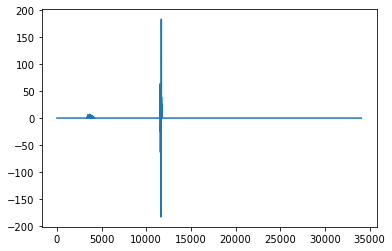

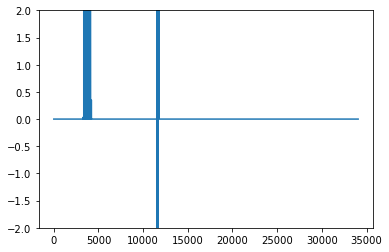

In [20]:
import matplotlib.pyplot as plt
plt.plot(lhs.coef)
plt.show()
plt.plot(lhs.coef)
plt.ylim(-2,2)
plt.show()

In [21]:
class RHS:
    def __init__(self, ds, t):
        '''
        ds: xarray containing all geometry and ouptut results from RAS2D.
            Should follow UGRID conventions.
        params: A class instance containing additional parameters. 
            TBD if this will remain or if parameters will be integrated into xarray.
        t: timestep index  
        '''
        self.conc = np.zeros(len(ds['nface']))
        self.conc[3673] = 50
        self.vals = np.zeros(len(ds['nface']))
        seconds = ds['dt'].values[t] #  / np.timedelta64(1, 's'))
        self.vals[:] = ds['volume'][t] / seconds * self.conc  # eventually also need to add total-load source/sink term (M/T/L2)
        print(np.where(ds['volume'][t] > 0))
        
    def updateValues(self, vector, ds, t):
        seconds = ds['dt'].values[t] # / np.timedelta64(1, 's'))
        self.vals[:] = vector * ds['volume'][t] / seconds

In [22]:
rhs = RHS(ds_zarr, t)
b = rhs.vals

(array([3458, 3459, 3460, 3563, 3564, 3565, 3566, 3670, 3671, 3672, 3673,
       3777, 3778, 3779, 3780, 3884, 3885, 3886, 3887, 3991, 3992],
      dtype=int64),)


In [23]:
x = spsolve(A, b)

C:\Users\sjordan\Anaconda3\envs\ras2d_wq\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


### Try Diffusion Only

In [24]:
class LHS:
    def __init__(self, ds, t):
        '''
        ds: xarray containing all geometry and ouptut results from RAS2D.
            Should follow UGRID conventions.
        params: A class instance containing additional parameters. 
            TBD if this will remain or if parameters will be integrated into xarray.
        t: timestep index  
        '''
        return

    def updateValues(self, ds,  t):
        flow_out_indices = np.where(ds['advection_coeff'][t+1] > 0)[0]
        flow_in_indices = np.where(ds['advection_coeff'][t+1] < 0)[0]
        print(flow_in_indices)
        print(flow_out_indices)

        # initialize arrays that will define the sparse matrix
        len_val = len(ds['nedge']) * 2 + len(ds['nface']) * 2 + len(flow_out_indices) * 2 + len(flow_in_indices)*2
        self.rows = np.zeros(len_val)
        self.cols = np.zeros(len_val)
        self.coef = np.zeros(len_val)

        ###### diagonal terms - the "A" coefficient in the equations detailed above
        start = 0
        end = len(ds['nface'])
        self.rows[start:end] = ds['nface']
        self.cols[start:end] = ds['nface']
        seconds = ds['dt'].values[t] #  np.timedelta64(1, 's'))
        self.coef[start:end] = ds['volume'][t+1] / seconds + ds['sum_coeff_to_diffusion'][t+1]


        # add ghost cell volumes tp diagonals
        # note: these values are 0 for cell that is NOT a ghost cell
        # note: also 0 for any ghost cell that is not RECEIVING flow 
        start = end
        end = end + len(ds['nface'])
        self.rows[start:end] = ds['nface']
        self.cols[start:end] = ds['nface']
        self.coef[start:end] = ds['ghost_volumes'][t+1] / seconds
        plt.plot(range(len(ds['ghost_volumes'][t+1])), ds['ghost_volumes'][t+1].values)
        plt.title("Ghost Volumes")
        plt.show()

        ###### off-diagonal terms - diffusion
        f1 = ds['edge_face_connectivity'].T[0]
        f2 = ds['edge_face_connectivity'].T[1]

        # update indices
        start = end
        end = end + len(ds['nedge'])
        print(end-start)
        self.rows[start:end] = f1
        self.cols[start:end] = f2
        self.coef[start:end] = -1 * ds['coeff_to_diffusion'][t+1]

        # update indices and repeat 
        start = end
        end = end + len(ds['nedge'])
        print(end)
        print(len(self.coef))

        self.cols[start:end] = f1
        self.rows[start:end] = f2
        self.coef[start:end] = -1 * ds['coeff_to_diffusion'][t+1] # last one


[5692 5696 5700 6883 7071 7096 7097 7253 7262 7273 7287 7288 7528 7529
 7539 7552 7553 7752 7753 7758 7764 7770 7966 7976 7983 7984 7985 7987
 7989 8003 8199 8210 8212 8218 8225 8226 8229 8233 8425 8436 8442 8446
 8452 8453 8456 8670 8676 8683 8686 8688 8689 8890 8904 8907]
[5691 5694 5695 5697 5698 5699 6884 7095 7263 7286 7519 7551 7743 7763
 7766 7768 7769 7967 7975 7979 7986 8001 8002 8200 8211 8217 8224 8227
 8231 8232 8426 8435 8441 8447 8450 8454 8455 8660 8669 8675 8681 8682
 8687 8879 8880 8889 8895 8900 8905]


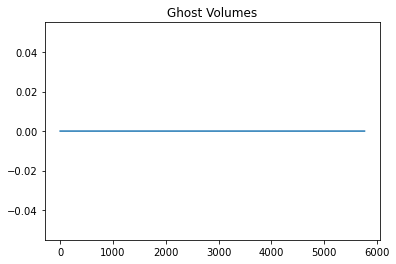

11164
33858
34064


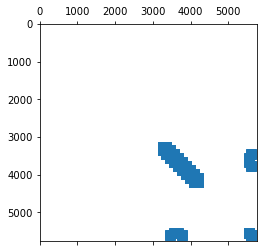

In [25]:
# test at single timestep
t = 38
lhs = LHS(ds_zarr, t)
lhs.updateValues(ds_zarr, t)
A = csr_matrix( (lhs.coef,(lhs.rows, lhs.cols)), shape=(len(ds_zarr['nface']),len(ds_zarr['nface'])))

# artificially produce solution
# A.dot(b)
plt.spy(A)

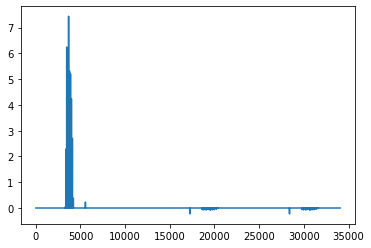

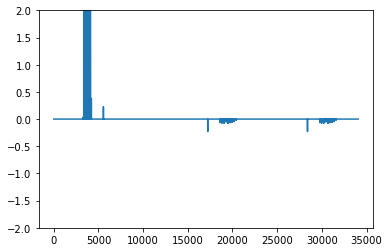

In [26]:
import matplotlib.pyplot as plt
plt.plot(lhs.coef)
plt.show()
plt.plot(lhs.coef)
plt.ylim(-2,2)
plt.show()

In [27]:
rhs = RHS(ds_zarr, t)
b = rhs.vals

(array([3458, 3459, 3460, 3563, 3564, 3565, 3566, 3670, 3671, 3672, 3673,
       3777, 3778, 3779, 3780, 3884, 3885, 3886, 3887, 3991, 3992],
      dtype=int64),)


In [28]:
x = spsolve(A, b)

C:\Users\sjordan\Anaconda3\envs\ras2d_wq\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


### Examine 3673

In [29]:
f1 = ds_zarr['edge_face_connectivity'].T[0]
f2 = ds_zarr['edge_face_connectivity'].T[1]

In [30]:
f1_3673 = np.where(f1 == 3673)[0]
f2_3673 = np.where(f2 == 3673)[0]

print(f1_3673, f2_3673)
f_conn = f1_3673.tolist() + f2_3673.tolist()
print(f_conn)


[5699 5700] [5692 5696]
[5699, 5700, 5692, 5696]


In [31]:
ds_zarr['edge_face_connectivity'][[5699, 5700, 5692, 5696]].values

array([[3673, 3780],
       [3673, 5554],
       [3566, 3673],
       [3672, 3673]])

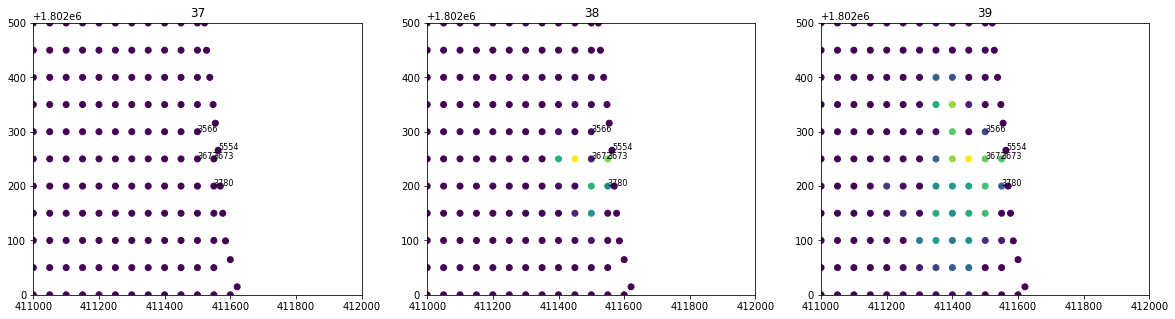

In [32]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)

times = [37, 38, 39]
for t in range(len(times)):
    x = ds_zarr.face_x
    y = ds_zarr.face_y
    ax[t].scatter(x,y, c=ds_zarr.volume[times[t]])
    ax[t].set_title(times[t])
    
for a in ax:
    a.set_ylim(1.8020 * 10**6, 1.8025*10**6)
    a.set_xlim(411000, 412000)
    for v in [3673, 3780, 5554, 3566, 3672]:
        a.annotate(v, (x[v], y[v]), fontsize=8)

plt.show()

In [33]:
t=38

In [34]:
print(ds_zarr['volume'][t][[ 3566, 3672, 3673, 3780, 5554]].values)

print(ds_zarr['volume'][t+1][[ 3566, 3672, 3673, 3780, 5554]].values)

[ 14.08325481  45.74048996 642.4418335  371.67510986   0.        ]
[ 423.59368896 1630.32678223 1529.90795898  637.29650879    0.        ]


In [35]:
ds_zarr['dt'][t].values

array(300.)

array([[3673, 3780],
       [3673, 5554],
       [3566, 3673],
       [3672, 3673]])

In [36]:
# coefficient to diffusion term
print(ds_zarr['edge_vertical_area'][t][f_conn].values)
print(ds_zarr['edge_vertical_area'][t+1][f_conn].values)

[ 4.93053102 16.2782402   0.29227513  5.61510801]
[28.7811985  47.07231903  1.71980536 21.19971466]


In [37]:
print(ds_zarr['face_to_face_dist'][f_conn].values)
print(ds_zarr['face_to_face_dist'][f_conn].values)

[50.         20.51928975 70.71067812 50.        ]
[50.         20.51928975 70.71067812 50.        ]


In [38]:
print(ds_zarr['edge_velocity'][t][f_conn].values)
print(ds_zarr['edge_velocity'][t+1][f_conn].values)

[ 0.8915532  0.        -0.3887053 -1.5578256]
[ 1.5692813 -3.8986886 -1.0065826 -2.1159754]


In [39]:
A.toarray()[3673][[3566, 3672, 3673, 3780, 5554]]

array([-2.43217206e-03, -4.23994293e-02,  5.43149240e+00, -5.75623970e-02,
       -2.29405207e-01])

### Diagonal

In [40]:
load = ds_zarr['volume'][t+1][3673].values / ds_zarr['dt'][t].values
diffusion = sum(ds_zarr['edge_vertical_area'][t+1][f_conn].values / ds_zarr['face_to_face_dist'][f_conn].values) * 0.1
advection_1 = ds_zarr['edge_velocity'][t+1][f_conn[0]].values * ds_zarr['edge_vertical_area'][t+1][f_conn[0]].values
advection_2 = sum(ds_zarr['edge_velocity'][t+1][f_conn[2:]].values * ds_zarr['edge_vertical_area'][t+1][f_conn[2:]].values * -1)

diag = load + diffusion + advection_1 + advection_2
print(diffusion - ds_zarr['sum_coeff_to_diffusion'][t+1][3673].values)
print(diag - A.toarray()[3673][3673])

-1.1102230246251565e-16
91.75499820607386


In [41]:
diff = (ds_zarr['edge_vertical_area'][t+1][f_conn].values * 0.1 / ds_zarr['face_to_face_dist'][f_conn].values * -1 )

In [42]:
adv = ds_zarr['edge_velocity'][t+1][f_conn[1]].values * ds_zarr['edge_vertical_area'][t+1][f_conn[1]].values + (ds_zarr['edge_vertical_area'][t+1][1].values * 0.1 / ds_zarr['face_to_face_dist'][1].values * -1)

In [43]:
print(diff, adv)
print(adv + diff[1])

[-0.0575624  -0.22940521 -0.00243217 -0.04239943] -183.52031145142064
-183.74971665794882


In [44]:
print(A.toarray()[3673][[3780, 5554, 3566, 3672]][0])
print(A.toarray()[3673][[3780, 5554, 3566, 3672]][1])
print(A.toarray()[3673][[3780, 5554, 3566, 3672]][2])
print(A.toarray()[3673][[3780, 5554, 3566, 3672]][3])


-0.05756239700317384
-0.2294052065281808
-0.002432172064528225
-0.04239942932128907


In [45]:
A.toarray()[3672][[3673]]

array([-0.04239943])

In [46]:
a = ds_zarr['edge_velocity'][t+1][f_conn[-1]].values * ds_zarr['edge_vertical_area'][t+1][f_conn[-1]].values
d = ds_zarr['edge_vertical_area'][t+1][f_conn[-1]].values / ds_zarr['face_to_face_dist'][f_conn[-1]].values * 0.1

In [47]:
a -d

-44.900473713079755

### Put Values in empty diagonals

Matrix is singular because all 0 values means it cannot solve. 

To do: ghost cells flowing IN to the matrix can have a volume based on advection into the real cells. Take care of that, and then the remainder can just be filled in.

In [272]:
t = 38

In [273]:
# 
empty_cells = np.where(ds_zarr['volume'][t] == 0)
print(empty_cells[0])

# remove ghost cells
f1 = ds_zarr['edge_face_connectivity'].T[0]

# number of real cells (cell 1 in a pair of cells that define an edge is always a real cell)
nreal = f1.max().values
print(nreal)

[   0    1    2 ... 5762 5763 5764]
5390


In [274]:
range(nreal)

range(0, 5390)

In [275]:
real_empty_cells = np.intersect1d(empty_cells[0], range(nreal))
print(real_empty_cells)
print(len(real_empty_cells))

[   0    1    2 ... 5387 5388 5389]
5369


In [276]:
# reconfigure lhs
class LHS:
    def __init__(self, ds, t):
        '''
        ds: xarray containing all geometry and ouptut results from RAS2D.
            Should follow UGRID conventions.
        params: A class instance containing additional parameters. 
            TBD if this will remain or if parameters will be integrated into xarray.
        t: timestep index  
        '''
        return

    def updateValues(self, ds,  t):
        f1 = ds['edge_face_connectivity'].T[0]
        f2 = ds['edge_face_connectivity'].T[1]
        # nreal = f1.max().values
        empty_cells = np.where(ds_zarr['volume'][t] == 0)[0]
        # real_empty_cells = np.intersect1d(empty_cells[0], range(nreal))

        flow_out_indices = np.where(ds['advection_coeff'][t+1] > 0)[0]
        flow_in_indices = np.where(ds['advection_coeff'][t+1] < 0)[0]


        # initialize arrays that will define the sparse matrix
        len_val = len(ds['nedge']) * 2 + len(ds['nface']) * 2 + len(flow_out_indices) * 2 + len(flow_in_indices)*2 + len(empty_cells)
        self.rows = np.zeros(len_val)
        self.cols = np.zeros(len_val)
        self.coef = np.zeros(len_val)
        # 1 where no volume and real cell 
        start = 0
        end = len(empty_cells)
        self.rows[start:end] = empty_cells
        self.cols[start:end] = empty_cells
        self.coef[start:end] = 1

        ###### diagonal terms - the "A" coefficient in the equations detailed above
        start = end
        end = end + len(ds['nface'])
        self.rows[start:end] = ds['nface']
        self.cols[start:end] = ds['nface']
        seconds = ds['dt'].values[t] #  np.timedelta64(1, 's'))
        print("seconds", seconds)
        self.coef[start:end] = ds['volume'][t+1] / seconds + ds['sum_coeff_to_diffusion'][t+1]


        # add ghost cell volumes tp diagonals
        # note: these values are 0 for cell that is NOT a ghost cell
        # note: also 0 for any ghost cell that is not RECEIVING flow 
        start = end
        end = end + len(ds['nface'])
        self.rows[start:end] = ds['nface']
        self.cols[start:end] = ds['nface']
        self.coef[start:end] = ds['ghost_volumes'][t+1] / seconds

        ###### advection
        # sometimes on-diagonal, sometimes off-diagonal (upwind differencing)

        # if statement to prevent errors if flow_out_indices or flow_in_indices have length of 0
        if len(flow_out_indices) > 0:
            # update indices
            start = end
            end = end + len(flow_out_indices)

            # where advection coefficient is positive, the concentration across the face will be the REFERENCE CELL 
            # so the the coefficient will go in the diagonal - both row and column will equal diag_cell
            self.rows[start:end] = ds['edge_face_connectivity'].T[0][flow_out_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[0][flow_out_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_out_indices]

            # subtract from corresponding neighbor cell (off-diagonal)
            start = end
            end = end + len(flow_out_indices)
            self.rows[start:end] = ds['edge_face_connectivity'].T[1][flow_out_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[0][flow_out_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_out_indices] * -1
        else:
            pass

        if len(flow_in_indices) > 0:
            # update indices
            start = end
            end = end + len(flow_in_indices)

            ## where it is negative, the concentration across the face will be the neighbor cell ("N")
            ## so the coefficient will be off-diagonal 
            self.rows[start:end] = ds['edge_face_connectivity'].T[0][flow_in_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[1][flow_in_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_in_indices] 

            ## update indices 
            start = end
            end = end + len(flow_in_indices)
            ## do the opposite on the corresponding diagonal 
            self.rows[start:end] = ds['edge_face_connectivity'].T[1][flow_in_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[1][flow_in_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_in_indices]  * -1 
        else:
            pass

        ###### off-diagonal terms - diffusion

        # update indices
        start = end
        end = end + len(ds['nedge'])
        self.rows[start:end] = f1
        self.cols[start:end] = f2
        self.coef[start:end] = -1 * ds['coeff_to_diffusion'][t+1]

        # update indices and repeat 
        start = end
        end = end + len(ds['nedge'])
        
        self.cols[start:end] = f1
        self.rows[start:end] = f2
        self.coef[start:end] = -1 * ds['coeff_to_diffusion'][t+1] # last one


seconds 300.0


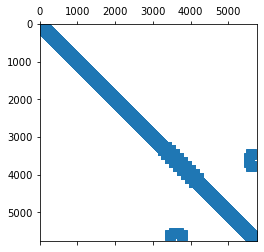

In [277]:
# test at single timestep
t = 38
lhs = LHS(ds_zarr, t)
lhs.updateValues(ds_zarr, t)
A = csr_matrix( (lhs.coef,(lhs.rows, lhs.cols)), shape=(len(ds_zarr['nface']),len(ds_zarr['nface'])))

# artificially produce solution
# A.dot(b)
plt.spy(A)

In [278]:
class RHS:
    def __init__(self, ds, t):
        '''
        ds: xarray containing all geometry and ouptut results from RAS2D.
            Should follow UGRID conventions.
        params: A class instance containing additional parameters. 
            TBD if this will remain or if parameters will be integrated into xarray.
        t: timestep index  
        '''
        self.conc = np.zeros(len(ds['nface']))
        self.conc[3673] = 50
        self.vals = np.zeros(len(ds['nface']))
        seconds = ds['dt'].values[t] #  / np.timedelta64(1, 's'))
        self.vals[:] = ds['volume'][t] / seconds * self.conc  # eventually also need to add total-load source/sink term (M/T/L2)
        print(np.where(ds['volume'][t] > 0))
        
    def updateValues(self, vector, ds, t):
        seconds = ds['dt'].values[t] # / np.timedelta64(1, 's'))
        self.vals[:] = vector * ds['volume'][t] / seconds

In [279]:
rhs = RHS(ds_zarr, t)
b = rhs.vals

(array([3458, 3459, 3460, 3563, 3564, 3565, 3566, 3670, 3671, 3672, 3673,
       3777, 3778, 3779, 3780, 3884, 3885, 3886, 3887, 3991, 3992],
      dtype=int64),)


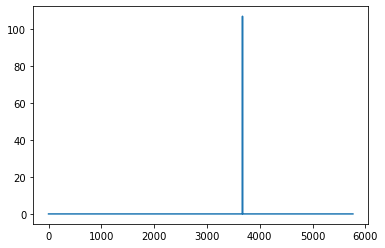

In [280]:
plt.plot(range(len(b)), b)

In [281]:
x = spsolve(A, b)

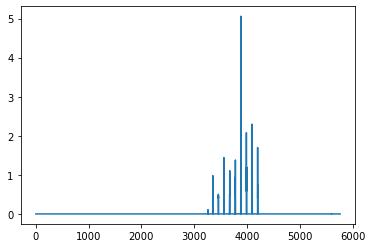

In [282]:
plt.plot(range(len(x)), x)

#### Plot It!

(array([3458, 3459, 3460, 3563, 3564, 3565, 3566, 3670, 3671, 3672, 3673,
       3777, 3778, 3779, 3780, 3884, 3885, 3886, 3887, 3991, 3992],
      dtype=int64),)
38
[0. 0. 0. ... 0. 0. 0.]
seconds 300.0
39
[0. 0. 0. ... 0. 0. 0.]
seconds 300.0
40
[0. 0. 0. ... 0. 0. 0.]
seconds 300.0
41
[0. 0. 0. ... 0. 0. 0.]
seconds 300.0
0
1
2
3


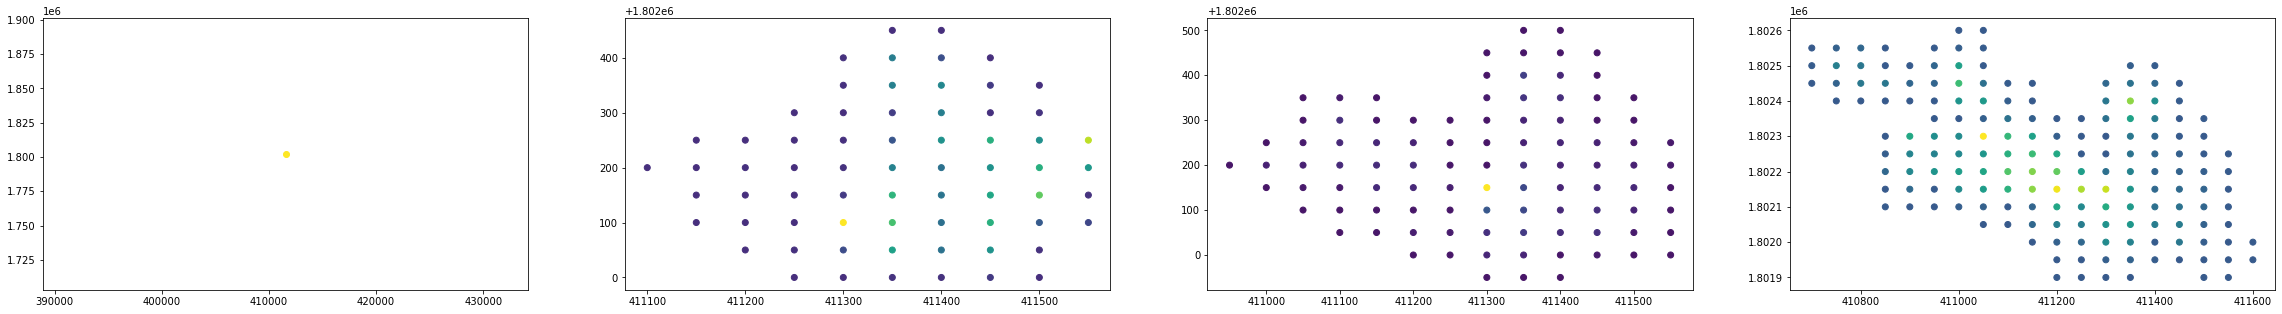

In [283]:
fig, ax = plt.subplots(1,4)
times = [38, 39, 40, 41]
b = RHS(ds_zarr, times[0])
output = np.zeros((10, len(ds_zarr['nface'])))
concs = np.zeros((10, len(ds_zarr['nface'])))


for t in range(len(times)):
    v = times[t]
    print(v)
    output[t] = b.vals
    # print(x)
    print(b.vals)
    lhs = LHS(ds_zarr, v)
    lhs.updateValues(ds_zarr, v)
    A = csr_matrix( (lhs.coef,(lhs.rows, lhs.cols)), shape=(len(ds_zarr['nface']),len(ds_zarr['nface'])))
    
    # ax[t].scatter(xs, ys, c=b.vals)
    x = spsolve(A, b.vals)
    b.updateValues(x, ds_zarr, v+1)
    concs[t+1] = x


for t in range(len(times)):
    print(t)
    ind = np.where(output[t] > 0)[0]
    ax[t].scatter(ds_zarr['face_x'][ind], ds_zarr['face_y'][ind], c=output[t][ind], vmin = -1)
    # print(output[t][ind])

fig.set_size_inches(40, 5)

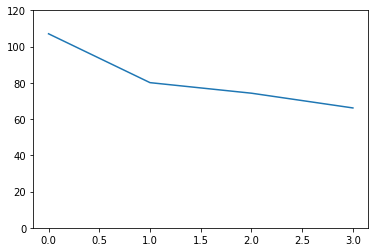

In [284]:
output_sum = []
for i in range(len(times)):
    s = sum(output[i])
    output_sum.append(s)
plt.plot(range(len(output_sum)), output_sum)
plt.ylim(0, 120)
plt.show()

Mass is decreasing over time. This is because the wrong time index was used in the LHS class was used. Fix below.

### Values in Empty Diagonals: Correct Time Index

In [36]:
# reconfigure lhs
class LHS:
    def __init__(self, ds, t):
        '''
        ds: xarray containing all geometry and ouptut results from RAS2D.
            Should follow UGRID conventions.
        params: A class instance containing additional parameters. 
            TBD if this will remain or if parameters will be integrated into xarray.
        t: timestep index  
        '''
        return

    def updateValues(self, ds,  t):
        f1 = ds['edge_face_connectivity'].T[0]
        f2 = ds['edge_face_connectivity'].T[1]
        # nreal = f1.max().values
        empty_cells = np.where(ds_zarr['volume'][t+1] == 0)[0]
        # real_empty_cells = np.intersect1d(empty_cells[0], range(nreal))

        flow_out_indices = np.where(ds['advection_coeff'][t+1] > 0)[0]
        flow_in_indices = np.where(ds['advection_coeff'][t+1] < 0)[0]


        # initialize arrays that will define the sparse matrix
        len_val = len(ds['nedge']) * 2 + len(ds['nface']) * 2 + len(flow_out_indices) * 2 + len(flow_in_indices)*2 + len(empty_cells)
        self.rows = np.zeros(len_val)
        self.cols = np.zeros(len_val)
        self.coef = np.zeros(len_val)
        # 1 where no volume and real cell 
        start = 0
        end = len(empty_cells)
        self.rows[start:end] = empty_cells
        self.cols[start:end] = empty_cells
        self.coef[start:end] = 1

        ###### diagonal terms - the "A" coefficient in the equations detailed above
        start = end
        end = end + len(ds['nface'])
        self.rows[start:end] = ds['nface']
        self.cols[start:end] = ds['nface']
        seconds = ds['dt'].values[t] #  np.timedelta64(1, 's'))
        print("seconds", seconds)
        self.coef[start:end] = ds['volume'][t+1] / seconds + ds['sum_coeff_to_diffusion'][t+1]


        # add ghost cell volumes tp diagonals
        # note: these values are 0 for cell that is NOT a ghost cell
        # note: also 0 for any ghost cell that is not RECEIVING flow 
        start = end
        end = end + len(ds['nface'])
        self.rows[start:end] = ds['nface']
        self.cols[start:end] = ds['nface']
        self.coef[start:end] = ds['ghost_volumes'][t+1] / seconds

        ###### advection
        # sometimes on-diagonal, sometimes off-diagonal (upwind differencing)

        # if statement to prevent errors if flow_out_indices or flow_in_indices have length of 0
        if len(flow_out_indices) > 0:
            # update indices
            start = end
            end = end + len(flow_out_indices)

            # where advection coefficient is positive, the concentration across the face will be the REFERENCE CELL 
            # so the the coefficient will go in the diagonal - both row and column will equal diag_cell
            self.rows[start:end] = ds['edge_face_connectivity'].T[0][flow_out_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[0][flow_out_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_out_indices]

            # subtract from corresponding neighbor cell (off-diagonal)
            start = end
            end = end + len(flow_out_indices)
            self.rows[start:end] = ds['edge_face_connectivity'].T[1][flow_out_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[0][flow_out_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_out_indices] * -1
        else:
            pass

        if len(flow_in_indices) > 0:
            # update indices
            start = end
            end = end + len(flow_in_indices)

            ## where it is negative, the concentration across the face will be the neighbor cell ("N")
            ## so the coefficient will be off-diagonal 
            self.rows[start:end] = ds['edge_face_connectivity'].T[0][flow_in_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[1][flow_in_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_in_indices] 

            ## update indices 
            start = end
            end = end + len(flow_in_indices)
            ## do the opposite on the corresponding diagonal 
            self.rows[start:end] = ds['edge_face_connectivity'].T[1][flow_in_indices]
            self.cols[start:end] = ds['edge_face_connectivity'].T[1][flow_in_indices]
            self.coef[start:end] = ds['advection_coeff'][t+1][flow_in_indices]  * -1 
        else:
            pass

        ###### off-diagonal terms - diffusion

        # update indices
        start = end
        end = end + len(ds['nedge'])
        self.rows[start:end] = f1
        self.cols[start:end] = f2
        self.coef[start:end] = -1 * ds['coeff_to_diffusion'][t+1]

        # update indices and repeat 
        start = end
        end = end + len(ds['nedge'])
        
        self.cols[start:end] = f1
        self.rows[start:end] = f2
        self.coef[start:end] = -1 * ds['coeff_to_diffusion'][t+1] # last one


seconds 300.0
(array([3458, 3459, 3460, 3563, 3564, 3565, 3566, 3670, 3671, 3672, 3673,
       3777, 3778, 3779, 3780, 3884, 3885, 3886, 3887, 3991, 3992],
      dtype=int64),)


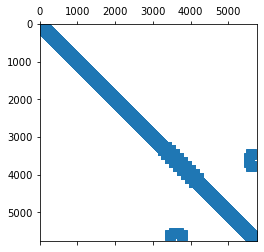

In [37]:
# test at single timestep
t = 38
lhs = LHS(ds_zarr, t)
lhs.updateValues(ds_zarr, t)
A = csr_matrix( (lhs.coef,(lhs.rows, lhs.cols)), shape=(len(ds_zarr['nface']),len(ds_zarr['nface'])))

# artificially produce solution
# A.dot(b)
plt.spy(A)

rhs = RHS(ds_zarr, t)
b = rhs.vals

x = spsolve(A, b)

#### Plot It!

(array([3458, 3459, 3460, 3563, 3564, 3565, 3566, 3670, 3671, 3672, 3673,
       3777, 3778, 3779, 3780, 3884, 3885, 3886, 3887, 3991, 3992],
      dtype=int64),)
38
[0. 0. 0. ... 0. 0. 0.]
seconds 300.0
39
[0. 0. 0. ... 0. 0. 0.]
seconds 300.0
40
[0. 0. 0. ... 0. 0. 0.]
seconds 300.0
41
[0. 0. 0. ... 0. 0. 0.]
seconds 300.0
37
107.07363891601562
38
107.06817495584083
39
107.0646780396634
40
107.06052924202798
41
107.06047465791151


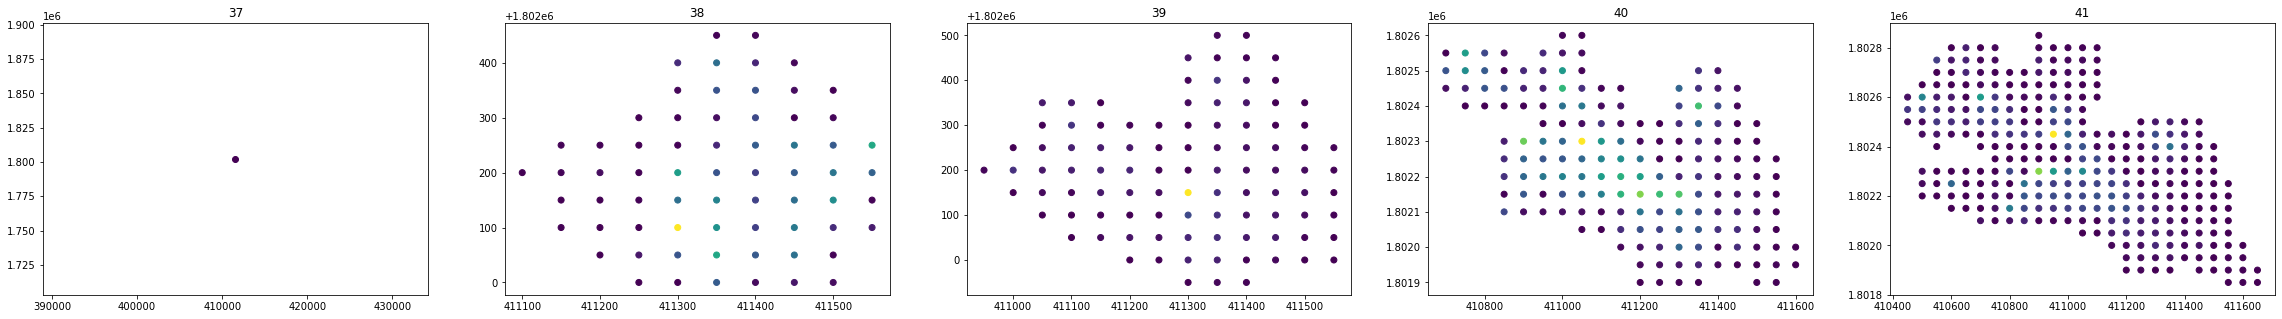

In [38]:
fig, ax = plt.subplots(1,5)
times = [38, 39, 40, 41]
b = RHS(ds_zarr, times[0])
output = np.zeros((10, len(ds_zarr['nface'])))
concs = np.zeros((10, len(ds_zarr['nface'])))
output[0] = b.vals

for t in range(len(times)):
    v = times[t]
    print(v)
    # print(x)
    print(b.vals)
    lhs = LHS(ds_zarr, v)
    lhs.updateValues(ds_zarr, v)
    A = csr_matrix( (lhs.coef,(lhs.rows, lhs.cols)), shape=(len(ds_zarr['nface']),len(ds_zarr['nface'])))
    
    # ax[t].scatter(xs, ys, c=b.vals)
    x = spsolve(A, b.vals)
    b.updateValues(x, ds_zarr, v+1)
    concs[t+1] = x
    output[t+1] = b.vals

all_times = [37, 38, 39, 40, 41]
for t in range(len(all_times)):
    print(all_times[t])
    ind = np.where(output[t] > 0)[0]
    print(sum(output[t]))
    ax[t].scatter(ds_zarr['face_x'][ind], ds_zarr['face_y'][ind], c=output[t][ind])
    ax[t].set_title(all_times[t])
    # print(output[t][ind])

fig.set_size_inches(40, 5)

In [39]:
output.shape

(10, 5765)

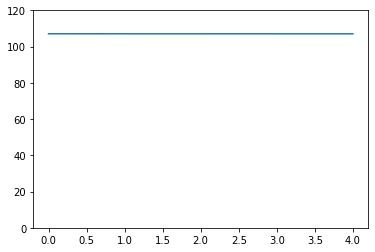

In [40]:
output_sum = []
for i in range(len(all_times)):
    s = sum(output[i])
    output_sum.append(s)
plt.plot(range(len(output_sum)), output_sum)
plt.ylim(0, 120)
plt.show()

Good! That fixed the problem of major amounts of load leaving the wet cells. 

0
here
1
2
3
4


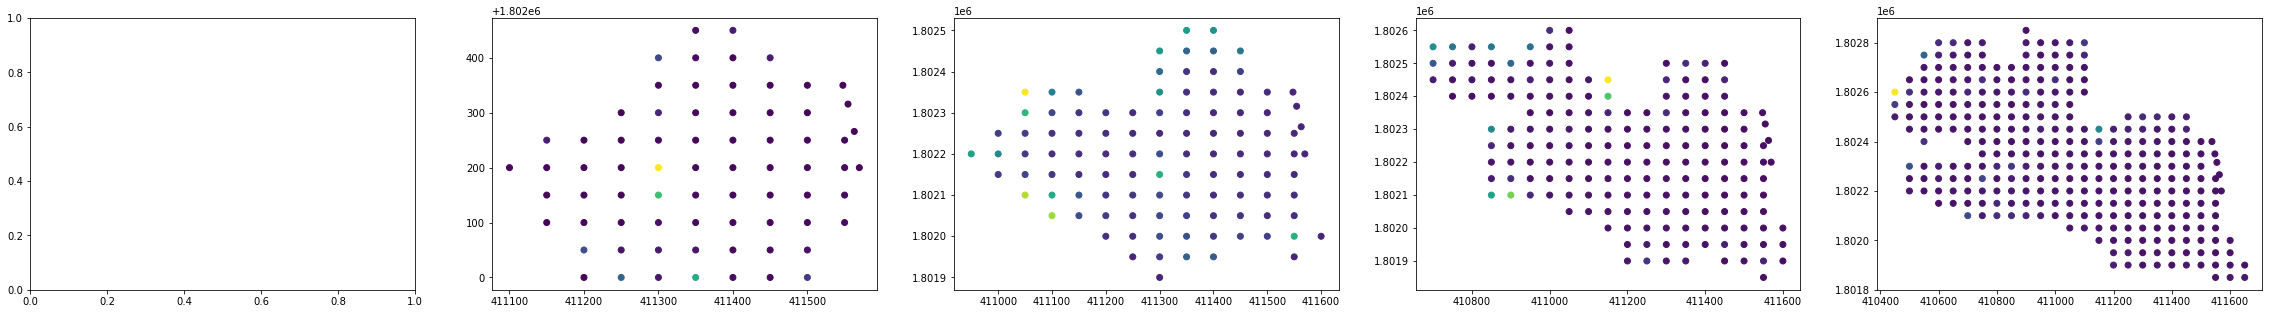

In [41]:
fig, ax = plt.subplots(1,5)
for t in range(len(all_times)):
    print(t)
    ind = np.where(concs[t] > 0)[0]
    if len(ind) > 0:
        ax[t].scatter(ds_zarr['face_x'][ind], ds_zarr['face_y'][ind], c=concs[t][ind], vmin = -1)
        # print(output[t][ind])
    else:
        print("here")
        pass

fig.set_size_inches(40, 5)

0
1
2
3
4


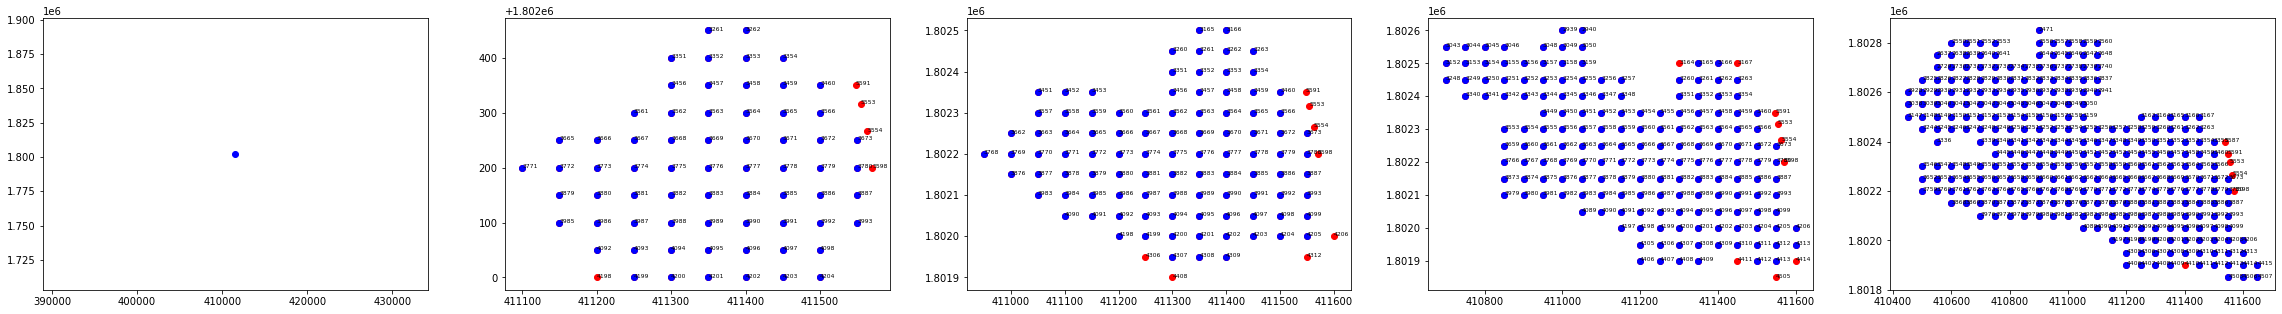

In [42]:
fig, ax = plt.subplots(1,5)
for t in range(len(all_times)):
    print(t)
    ind = np.where(concs[t] > 0)[0]
    if len(ind) > 0:
        ax[t].scatter(ds_zarr['face_x'][ind], ds_zarr['face_y'][ind], color='red')
        for v in ind:
            ax[t].annotate(v, (ds_zarr['face_x'][v], ds_zarr['face_y'][v]), fontsize=6)
    else:
        pass
    ind = np.where(output[t] != 0)[0]
    ax[t].scatter(ds_zarr['face_x'][ind], ds_zarr['face_y'][ind], color='blue')
 

fig.set_size_inches(40, 5)

range(5390, 5764)
0
1
2
3
4


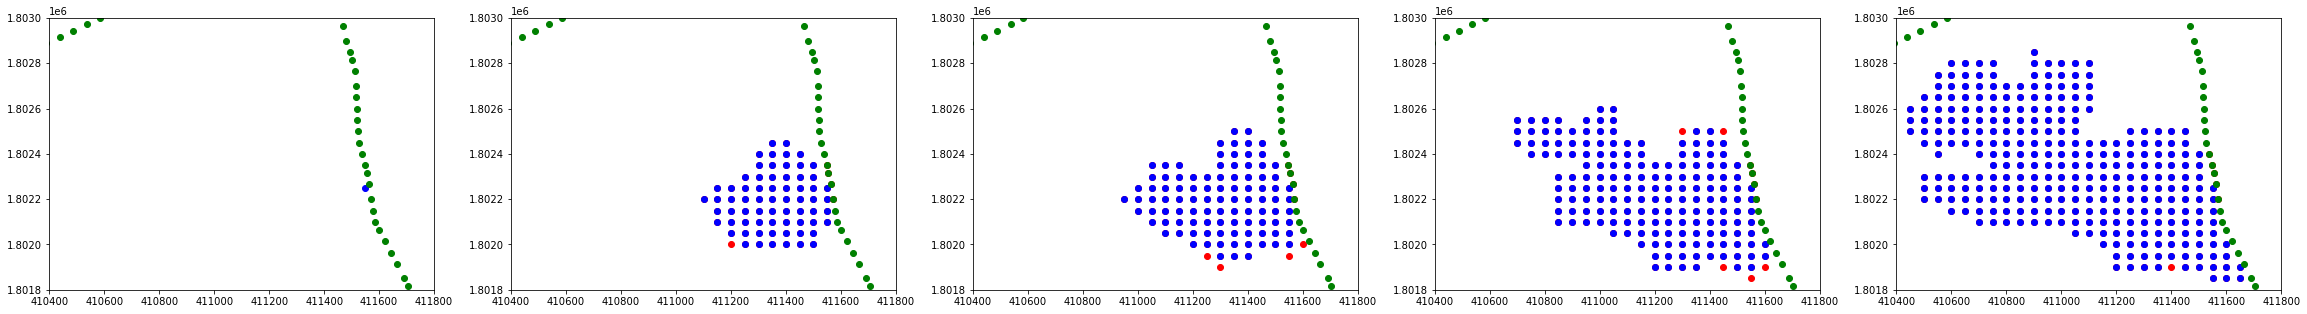

In [328]:
# are they boundary cells?
# find ghost cells giving
f1 = ds_zarr['edge_face_connectivity'].T[0]
f2 = ds_zarr['edge_face_connectivity'].T[1]
nreal = f1.max()
ncell = f2.max()
# print(nreal.values, ncell.values)
f2_ghost = np.where(f2 > nreal)[0]
r = range(nreal.values, ncell.values)
print(r)

fig, ax = plt.subplots(1,5)
for t in range(len(all_times)):
    print(t)
    ind = np.where(concs[t] > 0)[0]
    if len(ind) > 0:
        ax[t].scatter(ds_zarr['face_x'][ind], ds_zarr['face_y'][ind], color='red')
        # print(output[t][ind])
    else:
        pass
    ind = np.where(output[t] > 0)[0]
    ax[t].scatter(ds_zarr['face_x'][ind], ds_zarr['face_y'][ind], color='blue')
    
    ax[t].scatter(ds_zarr['face_x'][r], ds_zarr['face_y'][r], color='green')
    ax[t].set_ylim(1.8018*10**6, 1.8030*10**6)
    ax[t].set_xlim(410400, 411800)
 
fig.set_size_inches(40, 5)

It looks like there's some concentration in dry cells. Not impacting the volume? Not sure... 

### Ghost Cell Volumes In... to integrate

In [80]:
# find ghost cells giving
f1 = ds_zarr['edge_face_connectivity'].T[0]
f2 = ds_zarr['edge_face_connectivity'].T[1]

nreal = f1.max()
f2_ghost = np.where(f2 > nreal)[0]

ghost_vels_in = np.zeros((len(ds_zarr['time']), len(ds_zarr['nedge'])))

for t in range(len(ds_zarr['time'])):
    # positive velocities
    negative_velocity_indices = np.where(ds_zarr['edge_velocity'][t] < 0 )[0]

    # get intersection - this is where water is flowing IN from a ghost cell
    index_list = np.intersect1d(negative_velocity_indices, f2_ghost)

    if len(index_list) == 0:
        pass
    else:
        ghost_vels_in[t][index_list] = ds_zarr['edge_velocity'][t][index_list]


In [93]:
# calculate volume
ghost_flux_in_vols = ghost_vels_in * ds_zarr['edge_vertical_area'] * ds_zarr['dt'] * -1 

In [94]:
# transfer values (acssociated with EDGES) to corresponding CELLS
ghost_vols_in = np.zeros((len(ds_zarr['time']), len(ds_zarr['nface'])))
for t in range(len(ds_zarr['time'])):
    indices = np.where(ghost_flux_in_vols[t] > 0)[0]
    cell_ind = f2[indices]
    vals = ghost_flux_in_vols[t][indices]
    if len(cell_ind) > 0:
        ghost_vols_in[t][np.array(cell_ind)] = vals
    else:
        pass

In [95]:
# put data in xarray
ds_zarr["ghost_volumes_in"] = xr.DataArray(
    data = ghost_vols_in,
    dims = ("time", "nface"), 
    attrs={
        'units': 'ft3' # will need to update units based on prj file
})

#### In RHS

In [136]:
class RHS:
    def __init__(self, ds, t):
        '''
        ds: xarray containing all geometry and ouptut results from RAS2D.
            Should follow UGRID conventions.
        params: A class instance containing additional parameters. 
            TBD if this will remain or if parameters will be integrated into xarray.
        t: timestep index  
        '''
        self.conc = np.zeros(len(ds['nface']))
        self.conc[5554] = 50
        self.vals = np.zeros(len(ds['nface']))
        seconds = ds['dt'].values[t] #  / np.timedelta64(1, 's'))
        vol = ds['volume'][t] + ds['ghost_volumes_in'][t+1]
        print(vol[5554].values)
        self.vals[:] = vol / seconds * self.conc  # eventually also need to add total-load source/sink term (M/T/L2)
        # print(np.where(ds['volume'][t] > 0))
        
    def updateValues(self, vector, ds, t):
        seconds = ds['dt'].values[t] # / np.timedelta64(1, 's'))
        vol = ds['volume'][t] + ds['ghost_volumes_in'][t+1]
        self.vals[:] = vector * vol / seconds

In [137]:
f2[np.where(f1 == 3673)].values
np.where(f1 == 3673)

(array([5699, 5700], dtype=int64),)

0.0


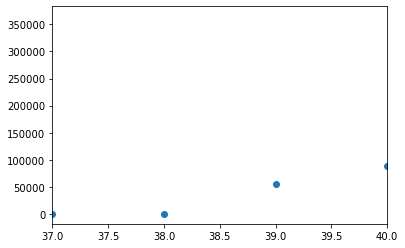

In [138]:
plt.scatter(range(len(ds_zarr['time'])), ds_zarr['ghost_volumes_in'][:, 5554])
plt.xlim(37, 40)
print(ds_zarr['ghost_volumes_in'][38, 5554].values)

0.0


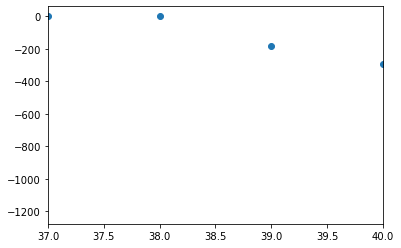

In [139]:
plt.scatter(range(len(ds_zarr['time'])), ds_zarr['advection_coeff'][:, 5700])
plt.xlim(37, 40)
print(ds_zarr['advection_coeff'][38, 5700].values)

(37.0, 40.0)

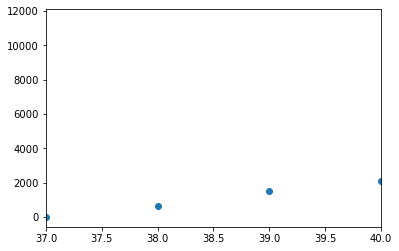

In [140]:
plt.scatter(range(len(ds_zarr['time'])), ds_zarr['volume'][:, 3673])
plt.xlim(37, 40)

seconds 300.0
88566.88274461085


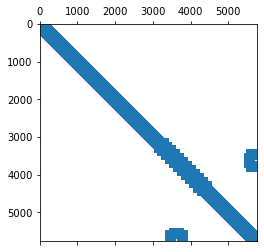

In [141]:
# test at single timestep
t = 39
lhs = LHS(ds_zarr, t)
lhs.updateValues(ds_zarr, t)
A = csr_matrix( (lhs.coef,(lhs.rows, lhs.cols)), shape=(len(ds_zarr['nface']),len(ds_zarr['nface'])))

# artificially produce solution
# A.dot(b)
plt.spy(A)

rhs = RHS(ds_zarr, t)
b = rhs.vals

x = spsolve(A, b)

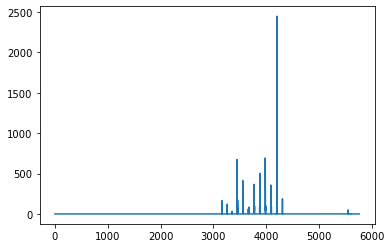

In [142]:
plt.plot(range(len(x)), x)

55056.09343542619
38
[0. 0. 0. ... 0. 0. 0.]
seconds 300.0
39
[0. 0. 0. ... 0. 0. 0.]
seconds 300.0
40
[0. 0. 0. ... 0. 0. 0.]
seconds 300.0
41
[0. 0. 0. ... 0. 0. 0.]
seconds 300.0
42
[0. 0. 0. ... 0. 0. 0.]
seconds 300.0
0
1
2
3
4


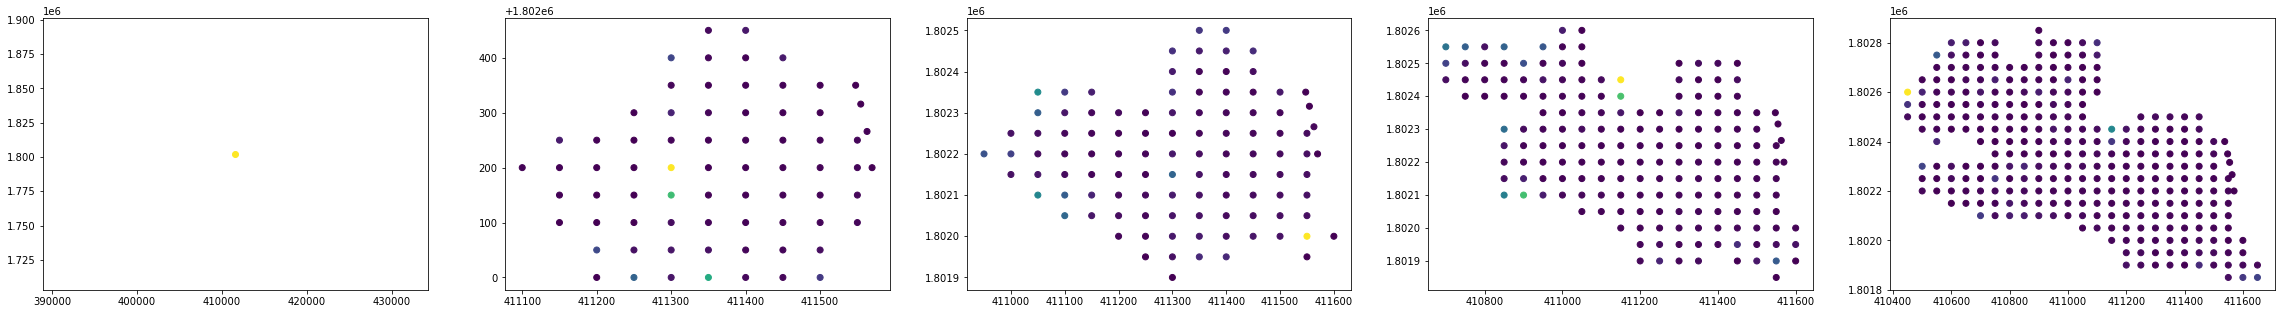

In [149]:
fig, ax = plt.subplots(1,5)
times = [38, 39, 40, 41, 42]
b = RHS(ds_zarr, times[0])
output = np.zeros((10, len(ds_zarr['nface'])))
concs = np.zeros((10, len(ds_zarr['nface'])))
output[0] = b.vals

for t in range(len(times)):
    v = times[t]
    print(v)
    # print(x)
    print(b.vals)
    lhs = LHS(ds_zarr, v)
    lhs.updateValues(ds_zarr, v)
    A = csr_matrix( (lhs.coef,(lhs.rows, lhs.cols)), shape=(len(ds_zarr['nface']),len(ds_zarr['nface'])))
    
    # ax[t].scatter(xs, ys, c=b.vals)
    x = spsolve(A, b.vals)
    b.updateValues(x, ds_zarr, v+1)
    concs[t+1] = x
    output[t+1] = x


for t in range(len(times)):
    print(t)
    ind = np.where(output[t] > 0)[0]
    ax[t].scatter(ds_zarr['face_x'][ind], ds_zarr['face_y'][ind], c=output[t][ind], vmin = -1)
    # print(output[t][ind])

fig.set_size_inches(40, 5)

## Old Stuff

In [109]:
b.max()

107.07363891601562

### Plot Results 



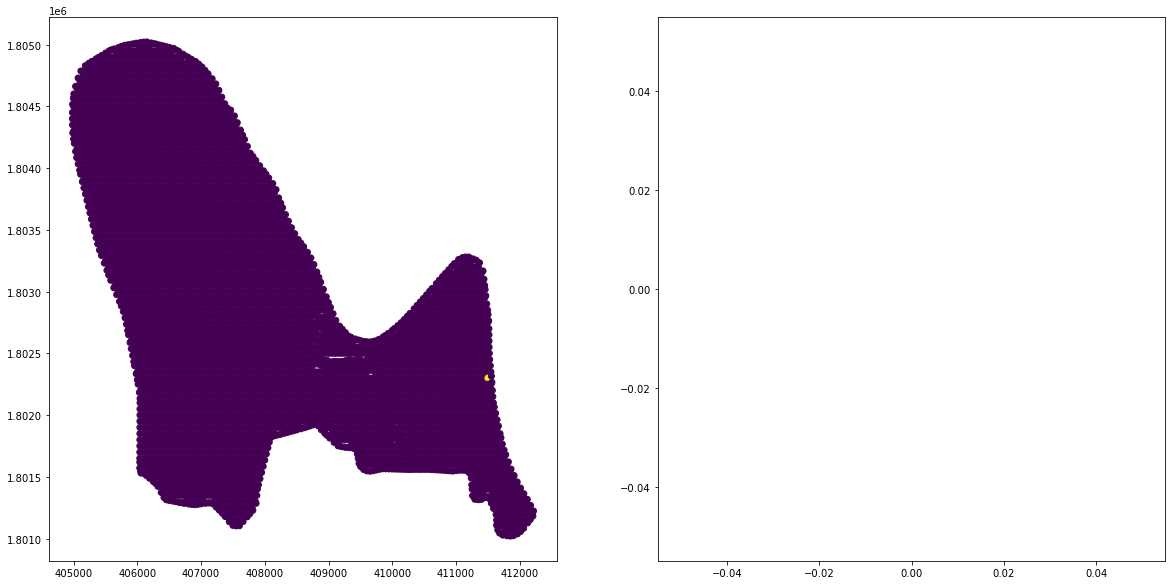

In [40]:
xs = ds_zarr.face_x
ys = ds_zarr.face_y

fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,10)
ax[0].scatter(xs,ys, c= rhs.vals)
rhs.updateValues(x, ds_zarr, 1)
ax[1].scatter(xs,ys, c=rhs.vals, vmin = 0, vmax = 50000)


In [22]:
rhs.vals

array([nan, nan, nan, ..., nan, nan, nan])

In [37]:
rhs.vals.sum() # decreased because stuff is leaving the box (to the ghost cells)

26825.876192745778

### Loop through Timesteps

0
[50000.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.]
1
[10076.10458233  2663.57943114   475.45963749  4954.357779
  2490.88137279   595.64133458  2806.49296016  2146.03307239
   617.32602287     0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.        ]
2
[2110.53330549 1151.3167121   325.62653355 1945.55406697 1522.59405708
  511.33740277 1548.30819627 1672.32673945  632.95025193    0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.        ]
3
[442.65650074 375.99408686 150.99406713 576.06737792 629.32574929
 281.76375648 575.48574078 834.49884221 406.77809809   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.        ]
4
[ 92.9752722

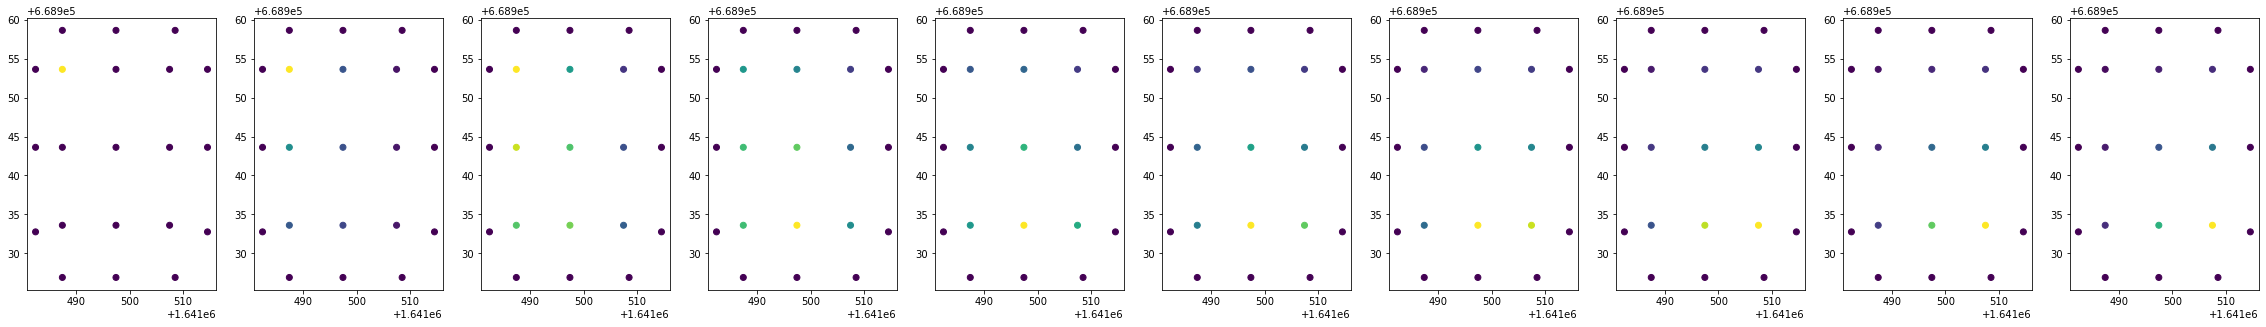

In [42]:
import matplotlib
fig, ax = plt.subplots(1,10)
t = 0
b = RHS(ds_zarr, t)
output = np.zeros((10, len(ds_zarr['nface'])))


for t in range(len(ds_zarr['time']) - 1):
    print(t)
    output[t] = b.vals
    # print(x)
    print(b.vals)
    lhs = LHS(ds_zarr, t)
    lhs.updateValues(ds_zarr, t)
    A = csr_matrix( (lhs.coef,(lhs.rows, lhs.cols)), shape=(len(ds_zarr['nface']),len(ds_zarr['nface'])))
    
    # ax[t].scatter(xs, ys, c=b.vals)
    x = spsolve(A, b.vals)
    b.updateValues(x, ds_zarr, t+1)


for t in range(len(ds_zarr['time']) - 1):
    
    ax[t].scatter(xs, ys, c=output[t])

fig.set_size_inches(40,5)

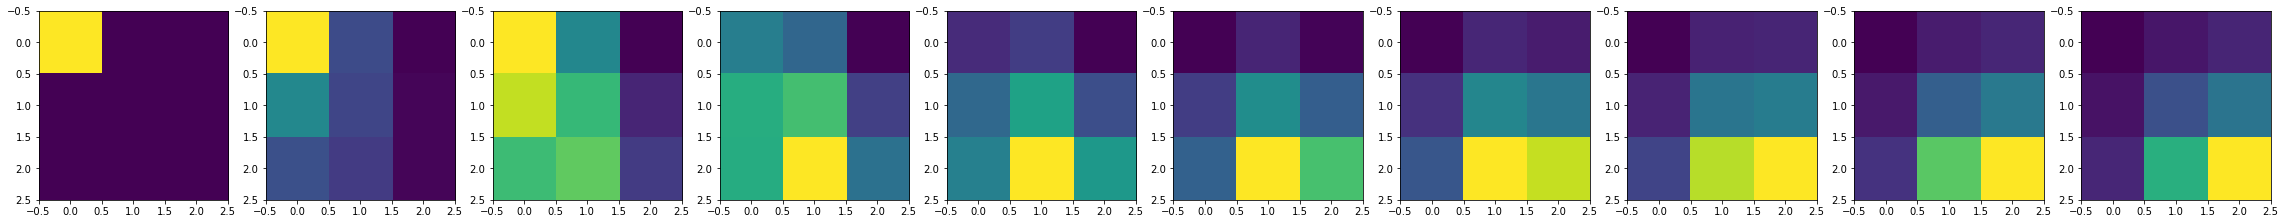

In [47]:
import matplotlib
fig, ax = plt.subplots(1,10)
for t in range(len(ds_zarr['time']) - 1):
    ax[t].imshow(output[t][0:9].reshape(3,3))

fig.set_size_inches(40,5)

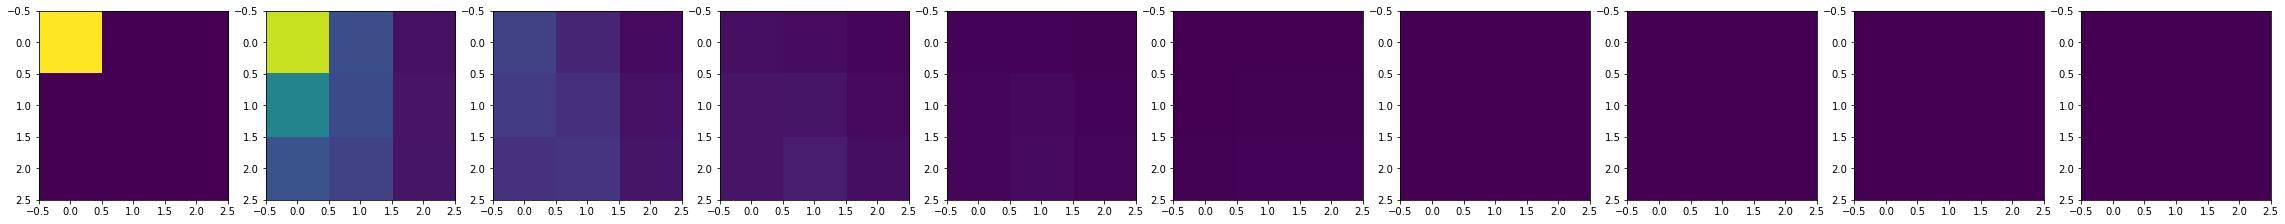

In [74]:
fig, ax = plt.subplots(1,10)
for t in range(len(ds_zarr['time']) - 1):
    ax[t].imshow(output[t][0:9].reshape(3,3), vmin=0, vmax=11000)

fig.set_size_inches(40,5)

In [68]:
# shows decrease over time a stuff leaves the actual cells to ghost cells 
for item in output:
    print(item.sum())
    print("-------")

50000.0
-------
26825.876192745778
-------
11420.547265611145
-------
4273.564219490768
-------
1477.293224049091
-------
484.18675614861235
-------
152.76221286827763
-------
46.8413645550005
-------
14.048587710975777
-------
4.1397431676849585
-------


## Will it flow across boundary face if starting out there?

Yes, but need to give load / concentration.

We will have to do something similar to how we handled the ghost cells where volume is flowing in (flux across face into that cell = volume at t+1 timestep). In this case, instead, the volume at the t timestep will be equal to the flux across the face where volume is moving FROM ghost cell TO real cell. 

Test implementation:

In [ ]:
class RHS:
    def __init__(self, ds,  t):
        '''
        ds: xarray containing all geometry and ouptut results from RAS2D.
            Should follow UGRID conventions.
        params: A class instance containing additional parameters. 
            TBD if this will remain or if parameters will be integrated into xarray.
        t: timestep index  
        '''
        self.conc = np.zeros(len(ds['nface']))
        self.conc[9] = 5000 # put a concentration in the top left ghost cell to start 
        self.vals = np.zeros(len(ds['nface']))
        seconds = (ds['dt'].values[t] / np.timedelta64(1, 's'))
        self.vals[:] = ds['volume'][t] / (seconds) * self.conc 
        
    def updateValues(self, vector, ds, t):
        seconds = (ds['dt'].values[t] / np.timedelta64(1, 's'))
        self.vals[:] = vector * ds['volume'][t] / (seconds)

0
[9.36111216e+01 3.19847941e+01 6.34750093e+00 5.90545783e+01
 3.85003501e+01 1.02314160e+01 3.79039085e+01 3.83329351e+01
 1.23314851e+01 1.77884133e+04 3.19847941e+01 6.34750093e+00
 1.02314160e+01 5.90545783e+01 3.79039085e+01 3.83329351e+01
 1.23314851e+01 9.36111216e+01 6.34750093e+00 3.79039085e+01
 1.23314851e+01]
[50000.     0.     0.     0.     0.     0.     0.     0.     0.  5000.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.]
1
[  793.6870071    214.00781927    32.04929768   413.87511651
   214.04501241    43.07730246   225.49677636   178.42010759
    43.15499933 18695.75312286   214.00781927    32.04929768
    43.07730246   413.87511651   225.49677636   178.42010759
    43.15499933   793.6870071     32.04929768   225.49677636
    43.15499933]
[11083.71504057  2929.93737425   523.00560124  5449.7935569
  2739.96951007   655.20546803  3087.14225618  2360.63637963
   679.05862516  5000.             0.             0.
     0.             0.     

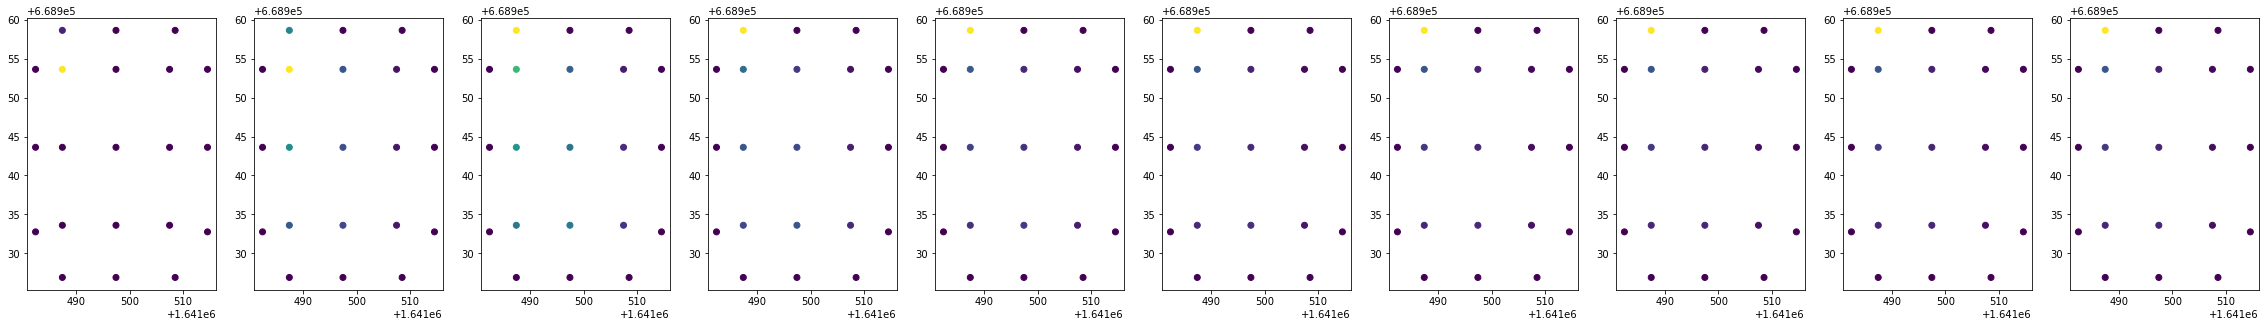

In [76]:
fig, ax = plt.subplots(1,10)
t = 0
b = RHS(ds_zarr, t)
b.vals[9] = 5000
output = np.zeros((10, len(ds_zarr['nface'])))


for t in range(len(ds_zarr['time']) - 1):
    print(t)
    output[t] = b.vals
    print(x)
    print(b.vals)
    lhs = LHS(ds_zarr, t)
    lhs.updateValues(ds_zarr, t)
    A = csr_matrix( (lhs.coef,(lhs.rows, lhs.cols)), shape=(len(ds_zarr['nface']),len(ds_zarr['nface'])))
    
    # ax[t].scatter(xs, ys, c=b.vals)
    x = spsolve(A, b.vals)
    b.updateValues(x, ds_zarr, t+1)
    b.vals[9] = 5000


for t in range(len(ds_zarr['time']) - 1):
    
    ax[t].scatter(xs, ys, c=output[t])

fig.set_size_inches(40,5)
    